# Projet 6 - Exploration

In [0]:
# Import the `pandas` library as `pd`
import pandas as pd
# Import pyplot from matplotlib as plt
import matplotlib.pyplot as plt

import seaborn as sns

# Import the `numpy` library as `np`
import numpy as np

import os
import re


from joblib import dump, load

In [0]:
# Librairies à utiliser
# import nltk
from bs4 import BeautifulSoup

In [0]:
from nltk import RegexpTokenizer, bigrams, download
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer

download('stopwords')
download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.matutils import corpus2dense

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
from collections import Counter

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#### 1.3.Contexte de mémoire

In [0]:
# cache directory for joblib objects
folder = "/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap"
try:
    os.mkdir(folder)
except FileExistsError:
    pass

### 2.Chargement de la base

In [0]:
data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/base/Query 5 Results.csv")

In [0]:
data.head()

,Id,CreationDate,Title,Body,Tags
0,38753898,2016-08-03 21:24:39,How to flatten a struct in a Spark dataframe?,<p>I have a dataframe with the following struc...,<java><apache-spark><apache-spark-sql>
1,38209656,2016-07-05 17:51:31,Get Angular2 routing working on IIS 7.5,<p>I have been learning Angular2. The routing ...,<html><angular><iis-7.5>
2,38209713,2016-07-05 17:55:41,How to make a responsive nav-bar using Angular...,<p>I'm trying to create a navigation bar using...,<angular><angular-material2>
3,47813927,2017-12-14 12:55:35,How to Refresh a Component in Angular,<p>I am working on an Angular project. I'm str...,<angular><routes><components><refresh>
4,38209815,2016-07-05 18:02:38,How do I make a slack bot leave a channel?,<p>bots cannot use the regular channels.leave ...,<bots><slack>


In [0]:
data.shape

(20236, 5)

In [0]:
data.Body[0]

'<p>I have a dataframe with the following structure:</p>\n\n<pre><code> |-- data: struct (nullable = true)\n |    |-- id: long (nullable = true)\n |    |-- keyNote: struct (nullable = true)\n |    |    |-- key: string (nullable = true)\n |    |    |-- note: string (nullable = true)\n |    |-- details: map (nullable = true)\n |    |    |-- key: string\n |    |    |-- value: string (valueContainsNull = true)\n</code></pre>\n\n<p>How it is possible to flatten the structure and create a new dataframe:</p>\n\n<pre><code>     |-- id: long (nullable = true)\n     |-- keyNote: struct (nullable = true)\n     |    |-- key: string (nullable = true)\n     |    |-- note: string (nullable = true)\n     |-- details: map (nullable = true)\n     |    |-- key: string\n     |    |-- value: string (valueContainsNull = true)\n</code></pre>\n\n<p>Is there something like explode, but for structs?</p>\n'

## Exploration
On va comparer les tags dominants selon des périodes (années).
On récupère les posts par semestre, ayant obtenu au moins une réponse, et un score supérieur à 10 (afin d'obtenir suffisamment de posts sans dépasser la limite fixée par stackexchange explorer)

In [0]:
str_directory = "/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/base/Requetes temporalité/"
files = sorted(os.listdir(str_directory))

In [0]:
def tokenize_tags(tags_full):
    list_tags = re.split(r'<|>', tags_full)
    tag_list = list(filter(None, list_tags))
    return tag_list

In [0]:
df_topten = pd.DataFrame()
for file in files:
  dataSem = pd.read_csv(str_directory + file)
  dataSem['Tags_tokens'] = dataSem['Tags'].apply(tokenize_tags)
  tag_list = []
  for tag_tk in dataSem.Tags_tokens:
    tag_list += tag_tk
  top_ten = pd.Series(tag_list).value_counts(normalize=True)[:5]
  df_top_ten = pd.DataFrame(top_ten, columns=[file[13:19]])
  df_topten = pd.concat([df_topten, df_top_ten], axis=1, join='outer', sort=False)
#   df_topten.fillna(0, inplace=True)

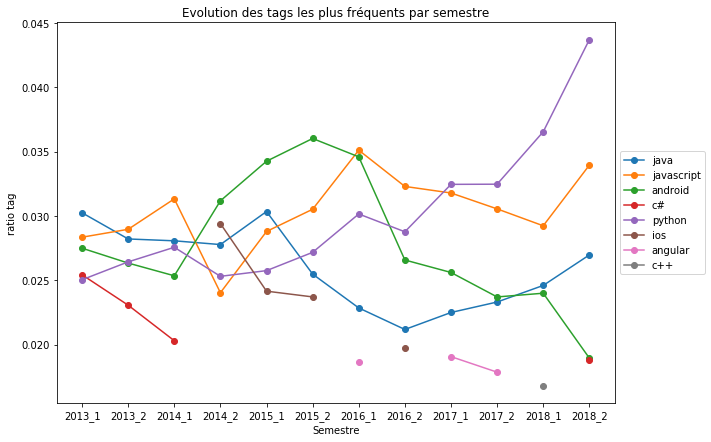

In [0]:
fig = plt.figure(figsize=(10,7))
plt.xlabel('Semestre')
plt.ylabel('ratio tag')
plt.title("Evolution des tags les plus fréquents par semestre")

for tag in df_topten.index:
  plt.plot(df_topten.T[tag], label=tag, marker='o')

plt.legend(loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

# Prétraitement
## Nettoyage du texte
On commence par supprimer les balises html du corps du message (colonne Body).

In [0]:
data['Body'] = data['Body'].apply(lambda x: BeautifulSoup(x, 'html.parser').text)

On constate que le titre comprend aussi des informations. on va donc concaténer titre et body en un seul champ

In [0]:
data['Body'] = data['Title'] + ' ' + data['Body']

On met le texte en minuscules.

In [0]:
data['Body'] = data['Body'].apply(lambda x: x.lower())

On remplace les termes tels que c++, c#,...### Analyse multivariée

In [0]:
# the dictionary has target_word : replacement_word pairs
wordDict = {
    "c++": "cplusplus",
    'c#': 'csharp',
    '.net': 'dotnet',
    'd3.js': 'd3js',
    'node.js': 'nodejs'
}

In [0]:
def word_replace(text):
    '''
    Replace words found in Worddict
    '''
    for key in wordDict:
        text = text.replace(key, wordDict[key])
    return text

In [0]:
data['Body_2'] = data['Body'].apply(word_replace)

tokenisation. Il faut prendre des précautions avec la particularité des données. On trouve en effet certains items spécifiques tels que d3.js ou c++ dont on doit conserver l'intégrité) Il faut également considérer les expressions avec une approche n-grams (http://www.albertauyeung.com/post/generating-ngrams-python/)

In [0]:
tokenizer = RegexpTokenizer(r'\w+')

In [0]:
sw = stopwords.words('english')

On définit une fonction tokenize_fct qui reçoit en argument un texte, et renvoie le résultat de la tokenisation après exclusion des stopwords. Elle applique également le stemming (algorithme de Porter) aux mots afin de ne conserver que leur racine.

In [0]:
stemmer = EnglishStemmer()

In [0]:
def tokenize_body(body_full):
    list_a = tokenizer.tokenize(body_full)
    token_list = [stemmer.stem(word) for word in list_a if (word not in sw and not word.isdigit())]
    return token_list

On applique alors cette fonction à la colonne Body, pour créer une colonne Body_tokens.

In [0]:
data['Body_tokens'] = data['Body_2'].apply(tokenize_body)

In [0]:
data['Body_tokens']

0        [flatten, struct, spark, datafram, datafram, f...
1        [get, angular2, rout, work, ii, learn, angular...
2        [make, respons, nav, bar, use, angular, materi...
3        [refresh, compon, angular, work, angular, proj...
4        [make, slack, bot, leav, channel, bot, cannot,...
5        [separ, digit, larg, number, csharp, code, cpl...
6        [java, locald, get, date, two, date, usablil, ...
7        [option, param, vuej, router, need, rout, cert...
8        [split, dictionari, list, insid, panda, column...
9        [struct, reorder, compil, suppos, struct, like...
10       [get, valu, remotemessag, fcm, onmessagereceiv...
11       [use, declar, variabl, rang, base, loop, examp...
12       [insert, current, datetim, postgresql, insert,...
13       [angular2, compon, undefin, execut, callback, ...
14       [call, multiprocess, pool, join, use, multipro...
15       [kera, tensorboard, plot, train, valid, scalar...
16       [chart, js, axe, label, font, size, chart, js,.

On peut aussi effectuer une lemmatisation à la place du stemming

In [0]:
wordnet_lemmatizer = WordNetLemmatizer()

In [0]:
def tokenize_body(body_full):
    list_a = tokenizer.tokenize(body_full)
    token_list = [wordnet_lemmatizer.lemmatize(word) for word in list_a if (word not in sw and not word.isdigit())]
    return token_list

In [0]:
data['Body_tokens'] = data['Body_2'].apply(tokenize_body)

In [0]:
data['Body_tokens']

0        [flatten, struct, spark, dataframe, dataframe,...
1        [get, angular2, routing, working, ii, learning...
2        [make, responsive, nav, bar, using, angular, m...
3        [refresh, component, angular, working, angular...
4        [make, slack, bot, leave, channel, bot, cannot...
5        [separating, digit, large, number, csharp, cod...
6        [java, localdate, get, date, two, date, usabli...
7        [optional, param, vuejs, router, need, route, ...
8        [splitting, dictionary, list, inside, panda, c...
9        [struct, reordering, compiler, suppose, struct...
10       [get, value, remotemessage, fcm, onmessagerece...
11       [using, declared, variable, range, based, loop...
12       [insert, current, datetime, postgresql, insert...
13       [angular2, component, undefined, executing, ca...
14       [call, multiprocessing, pool, join, using, mul...
15       [kera, tensorboard, plot, train, validation, s...
16       [chart, j, ax, label, font, size, chart, j, se.

On définit une fonction tokenize_fct qui reçoit en argument un texte, et renvoie le résultat de la tokenisation après exclusion des stopwords.

In [0]:
def tokenize_tags(tags_full):
    list_tags = re.split(r'<|>', tags_full)
    tag_list = list(filter(None, list_tags))
    return tag_list

On applique alors cette fonction à la colonne Tags, pour créer une colonne Tags_tokens.

In [0]:
data['Tags_tokens'] = data['Tags'].apply(tokenize_tags)

In [0]:
data.head(5)

,Id,CreationDate,Title,Body,Tags,Body_2,Body_tokens,Tags_tokens
0,38753898,2016-08-03 21:24:39,How to flatten a struct in a Spark dataframe?,how to flatten a struct in a spark dataframe? ...,<java><apache-spark><apache-spark-sql>,how to flatten a struct in a spark dataframe? ...,"[flatten, struct, spark, dataframe, dataframe,...","[java, apache-spark, apache-spark-sql]"
1,38209656,2016-07-05 17:51:31,Get Angular2 routing working on IIS 7.5,get angular2 routing working on iis 7.5 i have...,<html><angular><iis-7.5>,get angular2 routing working on iis 7.5 i have...,"[get, angular2, routing, working, ii, learning...","[html, angular, iis-7.5]"
2,38209713,2016-07-05 17:55:41,How to make a responsive nav-bar using Angular...,how to make a responsive nav-bar using angular...,<angular><angular-material2>,how to make a responsive nav-bar using angular...,"[make, responsive, nav, bar, using, angular, m...","[angular, angular-material2]"
3,47813927,2017-12-14 12:55:35,How to Refresh a Component in Angular,how to refresh a component in angular i am wor...,<angular><routes><components><refresh>,how to refresh a component in angular i am wor...,"[refresh, component, angular, working, angular...","[angular, routes, components, refresh]"
4,38209815,2016-07-05 18:02:38,How do I make a slack bot leave a channel?,how do i make a slack bot leave a channel? bot...,<bots><slack>,how do i make a slack bot leave a channel? bot...,"[make, slack, bot, leave, channel, bot, cannot...","[bots, slack]"


On peut constater que des expression telles que c#, c++, .net, les indices de révision (par ex 2.1.4) ne sont pas conservés, et deviennent c, c, net, 2 1 4. On va donc utiliser un dictionnaire pour remplacer ces termes par des mots qui ne seront pas tronqués (par exemple c++ devient cplusplus, etc...)

Extraction des features bag-of-word:

suppression stop-words
seuil fréquence mot
normalisation des mots (racines, ...)

In [0]:
def bigrams_body(body_full):
    tokens = tokenizer.tokenize(body_full.lower())
    bigram_list = list(bigrams(tokens))
    return bigram_list

In [0]:
# on utilise la fonciotn bigrams de NLTK pour récupérer les bi-grammes du champ body
data['Body_bigrams'] = data['Body_2'].apply(bigrams_body)

In [0]:
data.head(5)

,Id,CreationDate,Title,Body,Tags,Body_2,Body_tokens,Tags_tokens,Body_bigrams
0,38753898,2016-08-03 21:24:39,How to flatten a struct in a Spark dataframe?,how to flatten a struct in a spark dataframe? ...,<java><apache-spark><apache-spark-sql>,how to flatten a struct in a spark dataframe? ...,"[flatten, struct, spark, dataframe, dataframe,...","[java, apache-spark, apache-spark-sql]","[(how, to), (to, flatten), (flatten, a), (a, s..."
1,38209656,2016-07-05 17:51:31,Get Angular2 routing working on IIS 7.5,get angular2 routing working on iis 7.5 i have...,<html><angular><iis-7.5>,get angular2 routing working on iis 7.5 i have...,"[get, angular2, routing, working, ii, learning...","[html, angular, iis-7.5]","[(get, angular2), (angular2, routing), (routin..."
2,38209713,2016-07-05 17:55:41,How to make a responsive nav-bar using Angular...,how to make a responsive nav-bar using angular...,<angular><angular-material2>,how to make a responsive nav-bar using angular...,"[make, responsive, nav, bar, using, angular, m...","[angular, angular-material2]","[(how, to), (to, make), (make, a), (a, respons..."
3,47813927,2017-12-14 12:55:35,How to Refresh a Component in Angular,how to refresh a component in angular i am wor...,<angular><routes><components><refresh>,how to refresh a component in angular i am wor...,"[refresh, component, angular, working, angular...","[angular, routes, components, refresh]","[(how, to), (to, refresh), (refresh, a), (a, c..."
4,38209815,2016-07-05 18:02:38,How do I make a slack bot leave a channel?,how do i make a slack bot leave a channel? bot...,<bots><slack>,how do i make a slack bot leave a channel? bot...,"[make, slack, bot, leave, channel, bot, cannot...","[bots, slack]","[(how, do), (do, i), (i, make), (make, a), (a,..."


In [0]:
def join_body_tokens(body):
    return " ".join(body)

In [0]:
data['Body_tokens_2'] = data['Body_tokens'].apply(join_body_tokens)

## Réduction de dimension

In [0]:
X = data['Body_tokens_2']
y = data['Tags_tokens']

In [0]:
mlb = MultiLabelBinarizer()

In [0]:
y = mlb.fit_transform(y)

In [0]:
y = pd.DataFrame(y, columns=mlb.classes_)

In [0]:
y.shape

(20236, 6550)

In [0]:
y.head(5)

,.bash-profile,.class-file,.d.ts,.htaccess,.net,.net-2.0,.net-4.0,.net-4.5,.net-4.6,.net-4.6.1,.net-4.7,.net-assembly,.net-core,.net-core-2.0,.net-core-2.1,.net-core-3.0,.net-core-rc2,.net-framework-version,.net-native,.net-standard,.net-standard-1.4,.net-standard-1.5,.net-standard-1.6,.net-standard-2.0,2-way-object-databinding,32-bit,32bit-64bit,32feet,360-panorama-viewer,64-bit,aapt,aapt2,aar,abaddressbook,abbreviation,abc,abi,abort,absolute,absolute-path,...,yacc,yadcf,yahoo-api,yahoo-finance,yaml,yarn,yarnpkg,year2038,yeoman,yield,yield-from,yield-return,yii,yii2,yoast,youtube,youtube-api,youtube-channels,youtube-data-api,youtube-dl,youtube-iframe-api,youtube-livestreaming-api,yum,yuv,z-index,zapier,zapier-cli,zend-framework2,zero-initialization,zero-pad,zero-padding,zeromq,zip,zlib,zoneddatetime,zonejs,zoo,zsh,zurb-foundation,zurb-foundation-6
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
tag_count = y.sum(axis=0)

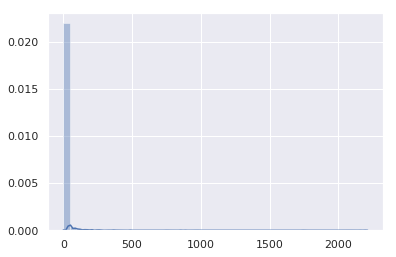

In [0]:

sns.set()
ax = sns.distplot(tag_count, bins = 50)

In [0]:
tag_count_size = pd.DataFrame(columns = ['seuil', 'nb'])
# tag_count_size = []
list_seuils = [0,1,2,3,4,5,10,20,50,100,150,200]
for cnt in list_seuils:
    tag_count_size.loc[cnt] = [cnt,tag_count[tag_count > cnt].size]

Text(0.5, 1.0, "Evolution du nombre de tags en fonction du nombre d'apparitions")

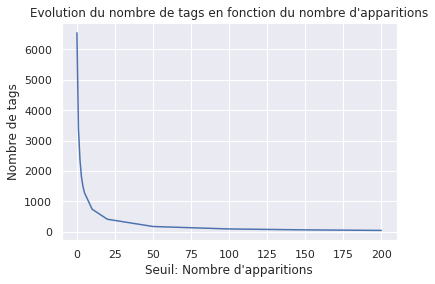

In [0]:
plt.plot(tag_count_size['seuil'], tag_count_size['nb'], label='linear')
plt.xlabel("Seuil: Nombre d'apparitions")
plt.ylabel('Nombre de tags')
plt.title("Evolution du nombre de tags en fonction du nombre d'apparitions")

In [0]:
tag_count_size


,seuil,nb
0,0,6550
1,1,3398
2,2,2373
3,3,1799
4,4,1483
5,5,1280
10,10,741
20,20,411
50,50,172
100,100,91


On fixe un seuil à 150 occurences d'un tag. Cela permettra de ne conserver qu'une centaine de tags différents.

In [0]:
seuil_tags = 150
y.drop([col for col, val in y.sum().iteritems() if val < seuil_tags], axis=1, inplace=True)

tag_count = y.sum(axis=0)

In [0]:
y.shape

(20236, 61)

In [0]:
y.head(5)

,.net,.net-core,amazon-web-services,android,android-gradle,android-studio,angular,angular-cli,apache-spark,arrays,asp.net,asp.net-core,c,c#,c++,c++11,c++17,css,docker,ecmascript-6,firebase,git,google-chrome,gradle,html,intellij-idea,ios,java,java-8,javascript,jquery,json,kotlin,language-lawyer,laravel,macos,node.js,npm,pandas,performance,php,python,python-3.x,r,react-native,reactjs,redux,spring,spring-boot,swift,swift3,tensorflow,typescript,unit-testing,visual-studio,visual-studio-2017,visual-studio-code,vue.js,webpack,xcode,xcode8
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


On supprime les lignes de X et y pour lesquelles il n'y a plus de label.

In [0]:
y = y[(y.T != 0).any()]

In [0]:
X = X[X.index.isin(y.index)]

In [0]:
X.shape

(17447,)

In [0]:
y.shape

(17447, 61)

il nous reste un peu plus de 17 000 posts avec labels.
On effectue ensuite la séparation des jeux d'entrainement et de test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13957,)
(3490,)
(13957, 61)
(3490, 61)


In [0]:
# Initialize the "CountVectorizer" object
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_df = 0.5,
                             max_features = 1000
                            ) 

In [0]:
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
X_train_count = vectorizer.fit_transform(X_train)

In [0]:
# Numpy arrays are easy to work with, so convert the result to an array
X_train_count = X_train_count.toarray()

In [0]:
X_train_count.shape

(13957, 1000)

In [0]:
X_train_count.sum()

1023665

In [0]:
X_train_count

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [0]:
X_test_count = vectorizer.transform(X_test)

In [0]:
X_test_doclen = X_test_count.toarray()

In [0]:
print(X_test_doclen)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [0]:
doc_len = X_test_doclen.sum(axis=1)

In [0]:
print(doc_len)

[140 120  48 ...  31  68  86]


In [0]:
vocab = vectorizer.get_feature_names()
print(vocab)

['__init__', 'aar', 'able', 'accept', 'access', 'according', 'account', 'achieve', 'action', 'active', 'activity', 'activitythread', 'actual', 'actually', 'add', 'added', 'adding', 'additional', 'address', 'admin', 'advance', 'ajax', 'alert', 'align', 'allow', 'allowed', 'already', 'also', 'always', 'anaconda', 'android', 'angular', 'angular2', 'animation', 'annotation', 'anonymous', 'another', 'answer', 'anyone', 'anything', 'apache', 'api', 'apk', 'app', 'appcompat', 'appcomponent', 'appdata', 'appears', 'append', 'apple', 'application', 'apply', 'appreciated', 'approach', 'apps', 'apt', 'args', 'argument', 'around', 'array', 'art', 'article', 'artifactid', 'aspdotnet', 'assembly', 'asset', 'async', 'attempt', 'attribute', 'auth', 'authentication', 'auto', 'automatically', 'available', 'avoid', 'await', 'aws', 'babel', 'back', 'background', 'bar', 'base', 'based', 'basic', 'bean', 'behavior', 'behaviour', 'best', 'beta', 'better', 'bin', 'binary', 'bind', 'binding', 'bit', 'block', '

In [0]:
# Sum up the counts of each vocabulary word
dist = np.sum(X_train_count, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print(count, tag)

305 __init__
306 aar
1037 able
291 accept
1474 access
327 according
425 account
369 achieve
1035 action
386 active
958 activity
1255 activitythread
290 actual
631 actually
2779 add
814 added
504 adding
251 additional
621 address
345 admin
278 advance
255 ajax
384 alert
321 align
438 allow
264 allowed
1020 already
2534 also
751 always
253 anaconda
16085 android
4484 angular
1117 angular2
368 animation
557 annotation
314 anonymous
1101 another
1146 answer
870 anyone
703 anything
930 apache
2843 api
591 apk
9617 app
356 appcompat
282 appcomponent
250 appdata
354 appears
329 append
663 apple
3186 application
843 apply
374 appreciated
489 approach
442 apps
283 apt
607 args
945 argument
504 around
2755 array
399 art
444 article
604 artifactid
748 aspdotnet
394 assembly
358 asset
824 async
297 attempt
795 attribute
532 auth
378 authentication
876 auto
340 automatically
707 available
346 avoid
534 await
469 aws
447 babel
693 back
842 background
1156 bar
740 base
664 based
335 basic
529 bean
57

## Sauvegarde

In [0]:
data_filename_memmap = os.path.join(folder, 'data_memmap')
dump(data, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/data_memmap']

In [0]:
data_filename_memmap = os.path.join(folder, 'tokeniz_memmap')
dump(tokenizer, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/tokeniz_memmap']

In [0]:
data_filename_memmap = os.path.join(folder, 'worddict_memmap')
dump(wordDict, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/worddict_memmap']

In [0]:
data_filename_memmap = os.path.join(folder, 'X_train_memmap')
dump(X_train, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/X_train_memmap']

In [0]:
data_filename_memmap = os.path.join(folder, 'X_train_count_memmap')
dump(X_train_count, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/X_train_count_memmap']

In [0]:
data_filename_memmap = os.path.join(folder, 'y_train_memmap')
dump(y_train, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/y_train_memmap']

In [0]:
data_filename_memmap = os.path.join(folder, 'X_test_memmap')
dump(X_test, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/X_test_memmap']

In [0]:
data_filename_memmap = os.path.join(folder, 'X_test_count_memmap')
dump(X_test_count, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/X_test_count_memmap']

In [0]:
data_filename_memmap = os.path.join(folder, 'y_test_memmap')
dump(y_test, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/y_test_memmap']

In [0]:
data_filename_memmap = os.path.join(folder, 'vector_memmap')
dump(vectorizer, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/vector_memmap']

In [0]:
data_filename_memmap = os.path.join(folder, 'vocab_memmap')
dump(vocab, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/vocab_memmap']

In [0]:
data_filename_memmap = os.path.join(folder, 'dist_terms_memmap')
dump(dist, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/dist_terms_memmap']

In [0]:
data_filename_memmap = os.path.join(folder, 'doc_len_memmap')
dump(doc_len, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/doc_len_memmap']